# Version 1 (Without Grid Extension)

In [ ]:
import torch
import torch.nn.functional as F
import math

class KANLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, base_activation=torch.nn.SiLU):
        """
        Initializes the KANLinear layer.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
            grid_size (int): Size of the grid for B-splines.
            spline_order (int): Order of the B-splines.
            base_activation (callable): Activation function for the base layer.
        """
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        # Calculate the spacing (h) for the grid
        h = (1 - -1) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + -1).expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        self.spline_scaler = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        self.base_activation = base_activation()
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize the parameters of the layer.
        """
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5))
        with torch.no_grad():
            self.spline_weight.data.fill_(0)
            self.spline_scaler.data.fill_(1)

    def b_splines(self, x):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        x = x.unsqueeze(-1)
        bases = ((x >= self.grid[:, :-1]) & (x < self.grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - self.grid[:, :-(k + 1)]) / (self.grid[:, k:-1] - self.grid[:, :-(k + 1)]) * bases[:, :, :-1]) + \
                    ((self.grid[:, k + 1:] - x) / (self.grid[:, k + 1:] - self.grid[:, 1:(-k)]) * bases[:, :, 1:])
        return bases.contiguous()

    def forward(self, x):
        """
        Forward pass of the KANLinear layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features).
        """
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), (self.spline_weight * self.spline_scaler.unsqueeze(-1)).view(self.out_features, -1))
        return base_output + spline_output


In [ ]:
class KAN(torch.nn.Module):
    def __init__(self, layers_hidden, grid_size=5, spline_order=3, base_activation=torch.nn.SiLU):
        """
        Initializes the KAN model.

        Args:
            layers_hidden (list): List of the number of neurons in each hidden layer.
            grid_size (int): Size of the grid for B-splines.
            spline_order (int): Order of the B-splines.
            base_activation (callable): Activation function for the base layer.
        """
        super(KAN, self).__init__()
        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(KANLinear(in_features, out_features, grid_size, spline_order, base_activation))

    def forward(self, x):
        """
        Forward pass of the KAN model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features of the last layer).
        """
        for layer in self.layers:
            x = layer(x)
        return x


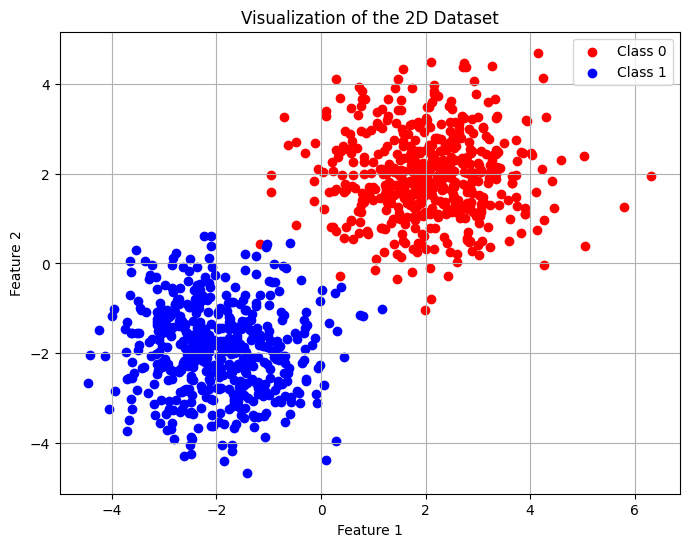

Epoch 1, Loss: 0.6652, Accuracy: 98.60%
Epoch 2, Loss: 0.6220, Accuracy: 98.10%
Epoch 3, Loss: 0.5662, Accuracy: 98.40%
Epoch 4, Loss: 0.5008, Accuracy: 98.90%
Epoch 5, Loss: 0.4318, Accuracy: 99.30%
Epoch 6, Loss: 0.3655, Accuracy: 99.60%
Epoch 7, Loss: 0.3045, Accuracy: 99.70%
Epoch 8, Loss: 0.2515, Accuracy: 99.70%
Epoch 9, Loss: 0.2074, Accuracy: 99.70%
Epoch 10, Loss: 0.1719, Accuracy: 99.70%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def generate_dataset(num_samples=1000):
    """
    Generate a synthetic 2D dataset with two classes.

    Args:
        num_samples (int): Total number of samples to generate.

    Returns:
        torch.Tensor: Features tensor of shape (num_samples, 2).
        torch.Tensor: Labels tensor of shape (num_samples,).
    """
    # Generate points for class 0
    x0 = np.random.randn(num_samples // 2, 2) + np.array([2, 2])
    # Generate points for class 1
    x1 = np.random.randn(num_samples // 2, 2) + np.array([-2, -2])
    # Combine the points
    x = np.vstack([x0, x1])
    # Create labels
    y = np.array([0] * (num_samples // 2) + [1] * (num_samples // 2))
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Generate dataset
x, y = generate_dataset(1000)
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(x[y==0][:, 0], x[y==0][:, 1], color='red', label='Class 0')
plt.scatter(x[y==1][:, 0], x[y==1][:, 1], color='blue', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of the 2D Dataset')
plt.legend()
plt.grid(True)
plt.show()

# Initialize the KAN model
model = KAN([2, 3, 3, 2])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
for epoch in range(10):
    total_loss = 0
    correct = 0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update loss and accuracy
        total_loss += loss.item()
        predicted = torch.argmax(output, axis=1)
        correct += (predicted == target).sum().item()

    # Print statistics
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}, Accuracy: {correct / len(dataset) * 100:.2f}%')


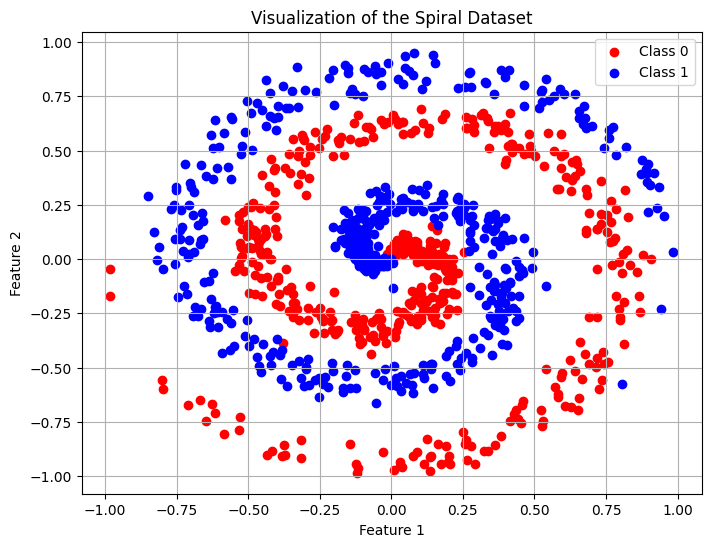

Epoch 1, Loss: 0.6874, Accuracy: 51.60%
Epoch 2, Loss: 0.6736, Accuracy: 58.20%
Epoch 3, Loss: 0.6660, Accuracy: 59.70%
Epoch 4, Loss: 0.6575, Accuracy: 57.70%
Epoch 5, Loss: 0.6484, Accuracy: 57.60%
Epoch 6, Loss: 0.6329, Accuracy: 58.90%
Epoch 7, Loss: 0.6060, Accuracy: 57.10%
Epoch 8, Loss: 0.5776, Accuracy: 61.00%
Epoch 9, Loss: 0.5320, Accuracy: 64.70%
Epoch 10, Loss: 0.4707, Accuracy: 75.20%
Epoch 11, Loss: 0.3967, Accuracy: 85.50%
Epoch 12, Loss: 0.3253, Accuracy: 87.10%
Epoch 13, Loss: 0.2868, Accuracy: 88.00%
Epoch 14, Loss: 0.2497, Accuracy: 90.50%
Epoch 15, Loss: 0.2401, Accuracy: 90.00%
Epoch 16, Loss: 0.2163, Accuracy: 90.10%
Epoch 17, Loss: 0.2092, Accuracy: 90.70%
Epoch 18, Loss: 0.2035, Accuracy: 90.90%
Epoch 19, Loss: 0.2121, Accuracy: 90.50%
Epoch 20, Loss: 0.1858, Accuracy: 92.20%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def generate_spiral_dataset(num_samples_per_class=500, num_classes=2):
    """
    Generate a synthetic 2D spiral dataset with multiple classes.

    Args:
        num_samples_per_class (int): Number of samples per class.
        num_classes (int): Number of classes.

    Returns:
        torch.Tensor: Features tensor of shape (num_samples_per_class * num_classes, 2).
        torch.Tensor: Labels tensor of shape (num_samples_per_class * num_classes,).
    """
    X = np.zeros((num_samples_per_class * num_classes, 2))  # Data matrix
    y = np.zeros(num_samples_per_class * num_classes, dtype='uint8')  # Class labels

    for j in range(num_classes):
        ix = range(num_samples_per_class * j, num_samples_per_class * (j + 1))
        r = np.linspace(0.0, 1, num_samples_per_class)  # Radius
        t = np.linspace(j * 4, (j + 1) * 4, num_samples_per_class) + np.random.randn(num_samples_per_class) * 0.2  # Theta
        X[ix] = np.c_[r * np.sin(t * 2.5), r * np.cos(t * 2.5)]
        y[ix] = j

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Generate spiral dataset
x, y = generate_spiral_dataset(num_samples_per_class=500, num_classes=2)
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(x[y==0][:, 0], x[y==0][:, 1], color='red', label='Class 0')
plt.scatter(x[y==1][:, 0], x[y==1][:, 1], color='blue', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of the Spiral Dataset')
plt.legend()
plt.grid(True)
plt.show()

# Initialize the KAN model
model = KAN([2, 50, 50, 2])  # Increasing model complexity to handle more complex dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
for epoch in range(20):  # Increasing epochs for better training
    total_loss = 0
    correct = 0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update loss and accuracy
        total_loss += loss.item()
        predicted = torch.argmax(output, axis=1)
        correct += (predicted == target).sum().item()

    # Print statistics
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}, Accuracy: {correct / len(dataset) * 100:.2f}%')


# Version 2 (With Grid Extension)

In [ ]:
class KANLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, base_activation=torch.nn.SiLU):
        """
        Initializes the KANLinear layer.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
            grid_size (int): Size of the grid for B-splines.
            spline_order (int): Order of the B-splines.
            base_activation (callable): Activation function for the base layer.
        """
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        # Calculate the spacing (h) for the grid
        h = (1 - -1) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + -1).expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        self.spline_scaler = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        self.base_activation = base_activation()
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize the parameters of the layer.
        """
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5))
        with torch.no_grad():
            self.spline_weight.data.fill_(0)
            self.spline_scaler.data.fill_(1)

    def b_splines(self, x):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        x = x.unsqueeze(-1)
        bases = ((x >= self.grid[:, :-1]) & (x < self.grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - self.grid[:, :-(k + 1)]) / (self.grid[:, k:-1] - self.grid[:, :-(k + 1)]) * bases[:, :, :-1]) + \
                    ((self.grid[:, k + 1:] - x) / (self.grid[:, k + 1:] - self.grid[:, 1:(-k)]) * bases[:, :, 1:])
        return bases.contiguous()

    def forward(self, x):
        """
        Forward pass of the KANLinear layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features).
        """
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), (self.spline_weight * self.spline_scaler.unsqueeze(-1)).view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def extend_grid(self, new_grid_size):
        """
        Extend the grid size to a finer resolution and update spline weights.

        Args:
            new_grid_size (int): The new size of the grid.
        """
        old_grid_size = self.grid_size
        h = (self.grid[0, -1] - self.grid[0, 0]) / new_grid_size
        new_grid = (
            torch.arange(-self.spline_order, new_grid_size + self.spline_order + 1) * h
            + self.grid[0, 0]
        ).expand(self.in_features, -1).contiguous()

        self.register_buffer("grid", new_grid)

        new_spline_weight = torch.nn.Parameter(
            torch.Tensor(self.out_features, self.in_features, new_grid_size + self.spline_order)
        )
        new_spline_weight.data.fill_(0)

        # Initialize the new spline weights by fitting the old weights to the new grid using least squares
        for i in range(self.out_features):
            for j in range(self.in_features):
                old_spline = self.spline_weight[i, j, :old_grid_size].cpu().numpy()
                old_grid_points = np.linspace(-1, 1, old_grid_size)
                new_grid_points = np.linspace(-1, 1, new_grid_size)

                # Least squares fitting
                A = np.vander(old_grid_points, N=new_grid_size, increasing=True)
                coef = np.linalg.lstsq(A, old_spline, rcond=None)[0]
                new_spline = np.polyval(coef[::-1], new_grid_points)

                new_spline_weight.data[i, j, :new_grid_size] = torch.tensor(new_spline, dtype=torch.float32)

        self.spline_weight = new_spline_weight
        self.grid_size = new_grid_size




In [ ]:
class KAN(torch.nn.Module):
    def __init__(self, layers_hidden, grid_size=5, spline_order=3, base_activation=torch.nn.SiLU):
        """
        Initializes the KAN model.

        Args:
            layers_hidden (list): List of the number of neurons in each hidden layer.
            grid_size (int): Size of the grid for B-splines.
            spline_order (int): Order of the B-splines.
            base_activation (callable): Activation function for the base layer.
        """
        super(KAN, self).__init__()
        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(KANLinear(in_features, out_features, grid_size, spline_order, base_activation))

    def forward(self, x):
        """
        Forward pass of the KAN model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features of the last layer).
        """
        for layer in self.layers:
            x = layer(x)
        return x


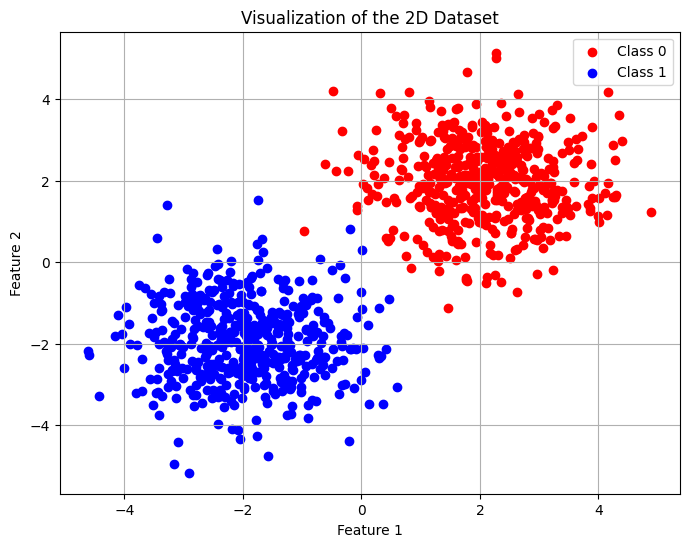

Epoch 1, Loss: 0.7269, Accuracy: 39.80%
Epoch 2, Loss: 0.7092, Accuracy: 57.00%
Epoch 3, Loss: 0.6941, Accuracy: 56.50%
Epoch 4, Loss: 0.6690, Accuracy: 73.80%
Epoch 5, Loss: 0.6242, Accuracy: 91.80%
Epoch 6, Loss: 0.6972, Accuracy: 31.60%
Epoch 7, Loss: 0.6854, Accuracy: 35.50%
Epoch 8, Loss: 0.6745, Accuracy: 38.90%
Epoch 9, Loss: 0.6635, Accuracy: 41.30%
Epoch 10, Loss: 0.6522, Accuracy: 55.80%


In [ ]:
def generate_dataset(num_samples=1000):
    """
    Generate a synthetic 2D dataset with two classes.

    Args:
        num_samples (int): Total number of samples to generate.

    Returns:
        torch.Tensor: Features tensor of shape (num_samples, 2).
        torch.Tensor: Labels tensor of shape (num_samples,).
    """
    # Generate points for class 0
    x0 = np.random.randn(num_samples // 2, 2) + np.array([2, 2])
    # Generate points for class 1
    x1 = np.random.randn(num_samples // 2, 2) + np.array([-2, -2])
    # Combine the points
    x = np.vstack([x0, x1])
    # Create labels
    y = np.array([0] * (num_samples // 2) + [1] * (num_samples // 2))
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Generate dataset
x, y = generate_dataset(1000)
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(x[y==0][:, 0], x[y==0][:, 1], color='red', label='Class 0')
plt.scatter(x[y==1][:, 0], x[y==1][:, 1], color='blue', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of the 2D Dataset')
plt.legend()
plt.grid(True)
plt.show()

# Initialize the KAN model
model = KAN([2, 3, 3, 2])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
for epoch in range(10):
    total_loss = 0
    correct = 0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update loss and accuracy
        total_loss += loss.item()
        predicted = torch.argmax(output, axis=1)
        correct += (predicted == target).sum().item()

    # Extend grid size for increased accuracy
    if epoch == 4:  # Example of extending grid at epoch 5
        for layer in model.layers:
            if isinstance(layer, KANLinear):
                layer.extend_grid(new_grid_size=10)

    # Print statistics
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}, Accuracy: {correct / len(dataset) * 100:.2f}%')


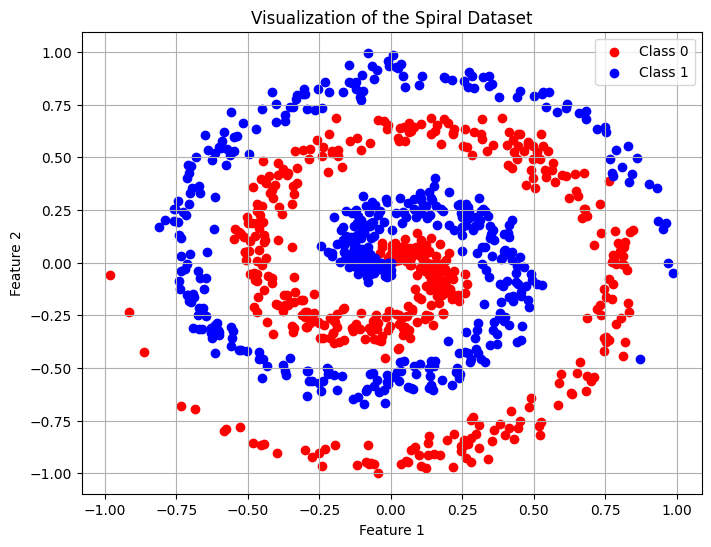

Epoch 1, Loss: 0.6883, Accuracy: 51.20%
Epoch 2, Loss: 0.6744, Accuracy: 55.50%
Epoch 3, Loss: 0.6649, Accuracy: 59.20%
Epoch 4, Loss: 0.6521, Accuracy: 59.40%
Epoch 5, Loss: 0.6406, Accuracy: 59.60%
Epoch 6, Loss: 0.6673, Accuracy: 61.00%
Epoch 7, Loss: 0.6648, Accuracy: 60.90%
Epoch 8, Loss: 0.6646, Accuracy: 60.30%
Epoch 9, Loss: 0.6636, Accuracy: 60.40%
Epoch 10, Loss: 0.6637, Accuracy: 60.40%


In [ ]:
def generate_spiral_dataset(num_samples_per_class=500, num_classes=2):
    """
    Generate a synthetic 2D spiral dataset with multiple classes.

    Args:
        num_samples_per_class (int): Number of samples per class.
        num_classes (int): Number of classes.

    Returns:
        torch.Tensor: Features tensor of shape (num_samples_per_class * num_classes, 2).
        torch.Tensor: Labels tensor of shape (num_samples_per_class * num_classes,).
    """
    X = np.zeros((num_samples_per_class * num_classes, 2))  # Data matrix
    y = np.zeros(num_samples_per_class * num_classes, dtype='uint8')  # Class labels

    for j in range(num_classes):
        ix = range(num_samples_per_class * j, num_samples_per_class * (j + 1))
        r = np.linspace(0.0, 1, num_samples_per_class)  # Radius
        t = np.linspace(j * 4, (j + 1) * 4, num_samples_per_class) + np.random.randn(num_samples_per_class) * 0.2  # Theta
        X[ix] = np.c_[r * np.sin(t * 2.5), r * np.cos(t * 2.5)]
        y[ix] = j

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Generate spiral dataset
x, y = generate_spiral_dataset(num_samples_per_class=500, num_classes=2)
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(x[y==0][:, 0], x[y==0][:, 1], color='red', label='Class 0')
plt.scatter(x[y==1][:, 0], x[y==1][:, 1], color='blue', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of the Spiral Dataset')
plt.legend()
plt.grid(True)
plt.show()

# Initialize the KAN model
model = KAN([2, 50, 50, 2])  # Increasing model complexity to handle more complex dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
for epoch in range(10):  # Increasing epochs for better training
    total_loss = 0
    correct = 0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update loss and accuracy
        total_loss += loss.item()
        predicted = torch.argmax(output, axis=1)
        correct += (predicted == target).sum().item()

        # Extend grid size for increased accuracy
    if epoch == 4:  # Example of extending grid at epoch 5
        for layer in model.layers:
            if isinstance(layer, KANLinear):
                layer.extend_grid(new_grid_size=10)

    # Print statistics
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}, Accuracy: {correct / len(dataset) * 100:.2f}%')
